In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


<h2>K-Fold Training and Evaluation</h2>

In [7]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 72)        100872

In [9]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/100
272/272 - 12s - loss: 1.4003 - accuracy: 0.5447 - val_loss: 1.3128 - val_accuracy: 0.4793
Epoch 2/100
272/272 - 2s - loss: 1.1253 - accuracy: 0.6110 - val_loss: 1.2576 - val_accuracy: 0.5496
Epoch 3/100
272/272 - 2s - loss: 1.0474 - accuracy: 0.6312 - val_loss: 1.6168 - val_accuracy: 0.5083
Epoch 4/100
272/272 - 2s - loss: 0.9351 - accuracy: 0.6529 - val_loss: 1.3841 - val_accuracy: 0.3554
Epoch 5/100
272/272 - 2s - loss: 0.8580 - accuracy: 0.6915 - val_loss: 1.9264 - val_accuracy: 0.1942
Epoch 6/100
272/272 - 2s - loss: 0.7708 - accuracy: 0.7228 - val_loss: 1.5629 - val_accuracy: 0.3884
Epoch 7/100
272/272 - 2s - loss: 0.7445 - accuracy: 0.7371 - val_loss: 0.6360 - val_accuracy: 0.7810
Epoch 8/100
272/272 - 2s - loss: 0.6739 - accuracy: 0.7822 - val_loss: 0.6605 - val_accuracy: 0.7727
Epoch 9/100
272/272 - 1s - loss: 0.6110 - accuracy: 0.7887 - val_loss: 0.6226 - val_accuracy: 0.7562
Epoch 10/100
272/272 - 2s - loss: 0.5471 - accuracy: 0.8126 - val_loss: 0.7447 - val_accur

Epoch 82/100
272/272 - 2s - loss: 0.0915 - accuracy: 0.9705 - val_loss: 0.1891 - val_accuracy: 0.9628
Epoch 83/100
272/272 - 2s - loss: 0.0752 - accuracy: 0.9738 - val_loss: 0.3684 - val_accuracy: 0.9008
Epoch 84/100
272/272 - 2s - loss: 0.0736 - accuracy: 0.9719 - val_loss: 0.2739 - val_accuracy: 0.9298
Epoch 85/100
272/272 - 2s - loss: 0.0990 - accuracy: 0.9678 - val_loss: 0.1972 - val_accuracy: 0.9339
Epoch 86/100
272/272 - 2s - loss: 0.0843 - accuracy: 0.9719 - val_loss: 0.8767 - val_accuracy: 0.8140
Epoch 87/100
272/272 - 2s - loss: 0.1115 - accuracy: 0.9664 - val_loss: 0.3092 - val_accuracy: 0.8926
Epoch 88/100
272/272 - 2s - loss: 0.1011 - accuracy: 0.9650 - val_loss: 0.1266 - val_accuracy: 0.9628
Epoch 89/100
272/272 - 2s - loss: 0.0598 - accuracy: 0.9811 - val_loss: 0.2969 - val_accuracy: 0.9256
Epoch 90/100
272/272 - 2s - loss: 0.0904 - accuracy: 0.9705 - val_loss: 0.1905 - val_accuracy: 0.9463
Epoch 91/100
272/272 - 2s - loss: 0.0646 - accuracy: 0.9774 - val_loss: 0.6361 - v

Epoch 63/100
272/272 - 2s - loss: 0.0942 - accuracy: 0.9696 - val_loss: 0.1347 - val_accuracy: 0.9628
Epoch 64/100
272/272 - 2s - loss: 0.0990 - accuracy: 0.9604 - val_loss: 0.1946 - val_accuracy: 0.9421
Epoch 65/100
272/272 - 2s - loss: 0.0921 - accuracy: 0.9701 - val_loss: 0.1666 - val_accuracy: 0.9628
Epoch 66/100
272/272 - 2s - loss: 0.1020 - accuracy: 0.9641 - val_loss: 0.4725 - val_accuracy: 0.8388
Epoch 67/100
272/272 - 2s - loss: 0.1486 - accuracy: 0.9535 - val_loss: 0.1417 - val_accuracy: 0.9587
Epoch 68/100
272/272 - 2s - loss: 0.1012 - accuracy: 0.9696 - val_loss: 0.2555 - val_accuracy: 0.9339
Epoch 69/100
272/272 - 2s - loss: 0.1040 - accuracy: 0.9664 - val_loss: 0.6446 - val_accuracy: 0.8099
Epoch 70/100
272/272 - 2s - loss: 0.1070 - accuracy: 0.9645 - val_loss: 0.1554 - val_accuracy: 0.9545
Epoch 71/100
272/272 - 2s - loss: 0.1096 - accuracy: 0.9664 - val_loss: 0.2853 - val_accuracy: 0.9050
Epoch 72/100
272/272 - 2s - loss: 0.1030 - accuracy: 0.9659 - val_loss: 0.2283 - v

Epoch 44/100
272/272 - 2s - loss: 0.1919 - accuracy: 0.9351 - val_loss: 0.3035 - val_accuracy: 0.9174
Epoch 45/100
272/272 - 2s - loss: 0.1800 - accuracy: 0.9411 - val_loss: 0.2426 - val_accuracy: 0.9215
Epoch 46/100
272/272 - 2s - loss: 0.1479 - accuracy: 0.9512 - val_loss: 0.5432 - val_accuracy: 0.8347
Epoch 47/100
272/272 - 2s - loss: 0.1578 - accuracy: 0.9448 - val_loss: 0.2062 - val_accuracy: 0.9545
Epoch 48/100
272/272 - 1s - loss: 0.1829 - accuracy: 0.9434 - val_loss: 0.6994 - val_accuracy: 0.7479
Epoch 49/100
272/272 - 2s - loss: 0.1413 - accuracy: 0.9535 - val_loss: 0.3147 - val_accuracy: 0.8926
Epoch 50/100
272/272 - 2s - loss: 0.1968 - accuracy: 0.9332 - val_loss: 0.7612 - val_accuracy: 0.7810
Epoch 51/100
272/272 - 2s - loss: 0.1430 - accuracy: 0.9461 - val_loss: 0.5589 - val_accuracy: 0.8264
Epoch 52/100
272/272 - 2s - loss: 0.1574 - accuracy: 0.9448 - val_loss: 0.1970 - val_accuracy: 0.9463
Epoch 53/100
272/272 - 2s - loss: 0.1472 - accuracy: 0.9475 - val_loss: 0.4493 - v

Epoch 25/100
272/272 - 2s - loss: 0.2953 - accuracy: 0.8946 - val_loss: 0.4189 - val_accuracy: 0.8636
Epoch 26/100
272/272 - 2s - loss: 0.2558 - accuracy: 0.9135 - val_loss: 0.3401 - val_accuracy: 0.9050
Epoch 27/100
272/272 - 2s - loss: 0.2873 - accuracy: 0.9043 - val_loss: 0.5230 - val_accuracy: 0.8099
Epoch 28/100
272/272 - 2s - loss: 0.2916 - accuracy: 0.9029 - val_loss: 0.9256 - val_accuracy: 0.6446
Epoch 29/100
272/272 - 2s - loss: 0.2768 - accuracy: 0.9093 - val_loss: 0.5039 - val_accuracy: 0.8140
Epoch 30/100
272/272 - 2s - loss: 0.2534 - accuracy: 0.9162 - val_loss: 0.2868 - val_accuracy: 0.8967
Epoch 31/100
272/272 - 2s - loss: 0.2433 - accuracy: 0.9208 - val_loss: 0.5857 - val_accuracy: 0.8017
Epoch 32/100
272/272 - 2s - loss: 0.2141 - accuracy: 0.9277 - val_loss: 0.5666 - val_accuracy: 0.8223
Epoch 33/100
272/272 - 2s - loss: 0.2560 - accuracy: 0.9144 - val_loss: 0.2751 - val_accuracy: 0.9132
Epoch 34/100
272/272 - 2s - loss: 0.2438 - accuracy: 0.9135 - val_loss: 0.1947 - v

Epoch 6/100
272/272 - 2s - loss: 0.8119 - accuracy: 0.7110 - val_loss: 0.8356 - val_accuracy: 0.7273
Epoch 7/100
272/272 - 2s - loss: 0.7818 - accuracy: 0.7285 - val_loss: 1.1368 - val_accuracy: 0.6198
Epoch 8/100
272/272 - 1s - loss: 0.6680 - accuracy: 0.7644 - val_loss: 1.2869 - val_accuracy: 0.6074
Epoch 9/100
272/272 - 2s - loss: 0.6701 - accuracy: 0.7671 - val_loss: 1.7154 - val_accuracy: 0.5744
Epoch 10/100
272/272 - 2s - loss: 0.5885 - accuracy: 0.7971 - val_loss: 1.7194 - val_accuracy: 0.6033
Epoch 11/100
272/272 - 2s - loss: 0.5728 - accuracy: 0.7994 - val_loss: 0.7830 - val_accuracy: 0.7562
Epoch 12/100
272/272 - 2s - loss: 0.5004 - accuracy: 0.8357 - val_loss: 0.9705 - val_accuracy: 0.7355
Epoch 13/100
272/272 - 2s - loss: 0.4850 - accuracy: 0.8399 - val_loss: 0.5429 - val_accuracy: 0.8017
Epoch 14/100
272/272 - 2s - loss: 0.4746 - accuracy: 0.8334 - val_loss: 0.5368 - val_accuracy: 0.7975
Epoch 15/100
272/272 - 2s - loss: 0.4536 - accuracy: 0.8472 - val_loss: 0.7295 - val_a

Epoch 87/100
272/272 - 2s - loss: 0.0686 - accuracy: 0.9728 - val_loss: 0.2735 - val_accuracy: 0.9215
Epoch 88/100
272/272 - 1s - loss: 0.0668 - accuracy: 0.9784 - val_loss: 0.1568 - val_accuracy: 0.9669
Epoch 89/100
272/272 - 2s - loss: 0.0587 - accuracy: 0.9802 - val_loss: 0.2198 - val_accuracy: 0.9504
Epoch 90/100
272/272 - 2s - loss: 0.0813 - accuracy: 0.9761 - val_loss: 0.2660 - val_accuracy: 0.9380
Epoch 91/100
272/272 - 2s - loss: 0.0771 - accuracy: 0.9765 - val_loss: 0.2825 - val_accuracy: 0.9008
Epoch 92/100
272/272 - 2s - loss: 0.0635 - accuracy: 0.9802 - val_loss: 0.2235 - val_accuracy: 0.9463
Epoch 93/100
272/272 - 2s - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.6670 - val_accuracy: 0.8636
Epoch 94/100
272/272 - 2s - loss: 0.0722 - accuracy: 0.9728 - val_loss: 0.1743 - val_accuracy: 0.9380
Epoch 95/100
272/272 - 2s - loss: 0.0848 - accuracy: 0.9728 - val_loss: 0.3597 - val_accuracy: 0.8967
Epoch 96/100
272/272 - 3s - loss: 0.0776 - accuracy: 0.9733 - val_loss: 0.1952 - v

In [10]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.90184726 0.75891021 0.86936621 0.95968514 0.95667498
 0.89081585 0.89838981]
precision sdev by class [0.         0.08812839 0.22976405 0.14241241 0.0281025  0.03815352
 0.09432304 0.06455077]
macro precision mean 0.904461182617303
macro precision sdev 0.02641750738315184
recall mean [0.88       0.832      0.75019763 0.87237288 0.97417417 0.87735849
 0.59733333 0.90052469]
recall sdev [0.16       0.14620534 0.10401792 0.0956508  0.01390491 0.05560146
 0.18006357 0.09902318]
macro recall mean 0.8354951499057499
macro recall sdev 0.03053909294161681
f1 mean [0.92777778 0.84971218 0.71709934 0.85876898 0.96649554 0.91405351
 0.68736531 0.89238764]
f1 sdev [0.09875772 0.04997811 0.11555841 0.08220463 0.01135905 0.03611794
 0.11263624 0.0302418 ]
macro f1 mean 0.8517075344874991
macro f1 sdev 0.027082167239027552
accuracy mean 0.9155047060503223
accuracy sdev 0.023257094522118785


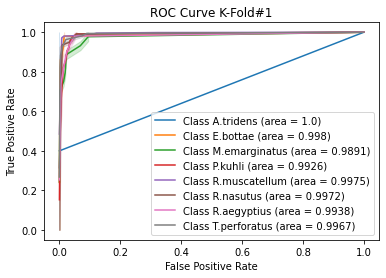

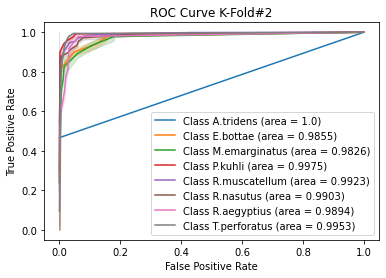

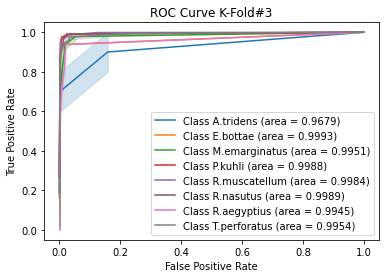

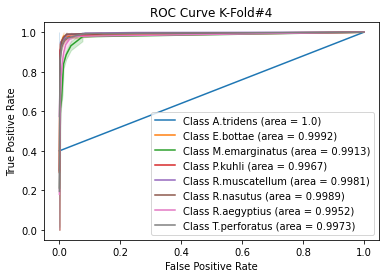

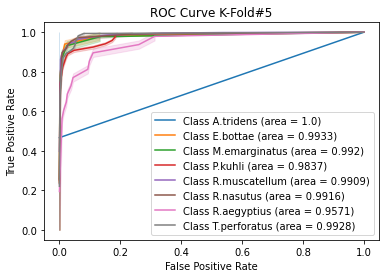

In [11]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

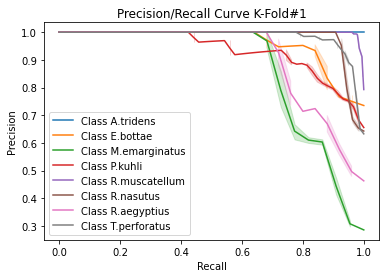

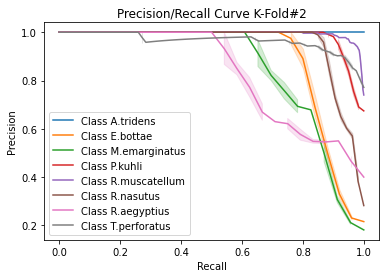

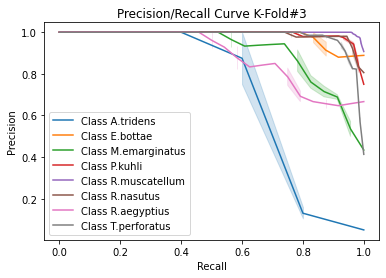

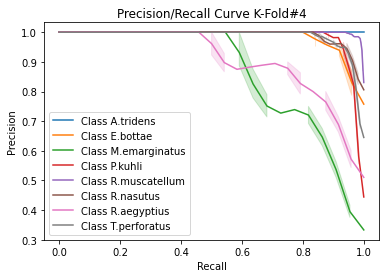

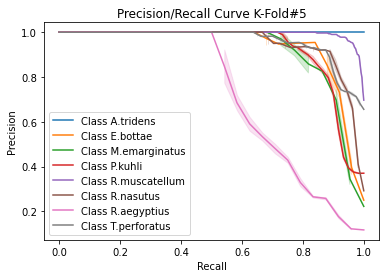

In [12]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  22   1   0   2   0   0   0]
 [  0   0  20   0   2   0   0   0]
 [  0   3  10  42   3   1   0   0]
 [  0   0   5   0 327   0   0   1]
 [  0   1   0   3   0  50   0   0]
 [  0   0  14   0   3   0   8   0]
 [  0   0   8   0   7   0   0  66]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  17   0   0   4   3   0   1]
 [  0   0  15   0   5   0   0   3]
 [  0   0   0  49   5   2   0   4]
 [  0   0   0   0 329   0   0   4]
 [  0   0   0   0   3  47   0   3]
 [  0   0   0   0   7   0  13   4]
 [  0   0   0   0   1   0   0  80]]


Confusion Matrix K-Fold #3

[[  3   0   1   0   0   0   1   0]
 [  0  24   0   0   0   0   0   0]
 [  0   0  19   1   0   0   2   1]
 [  0   0   1  57   0   1   0   1]
 [  0   5   3   0 316   0   0   9]
 [  0   1   0   0   0  51   1   1]
 [  0   1   1   2   0   0  18   2]
 [  0   0   1   0   0   0   0  80]]


Confusion Matrix K-Fold #4

[[  4   0   0   0   0   0   1   0]
 [  

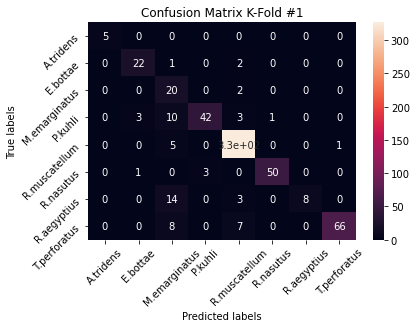

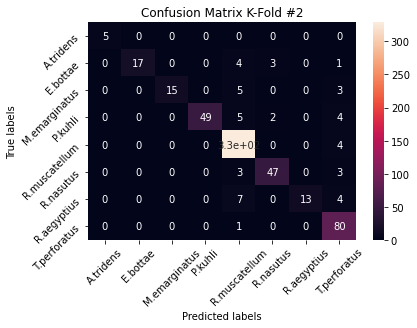

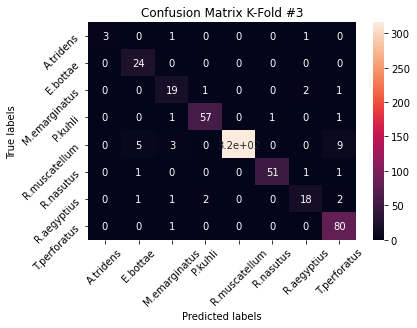

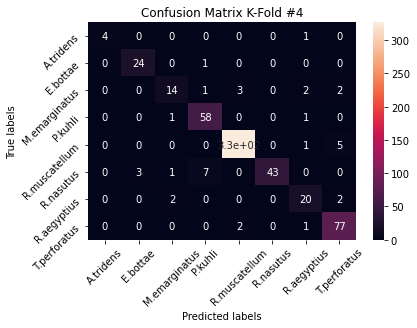

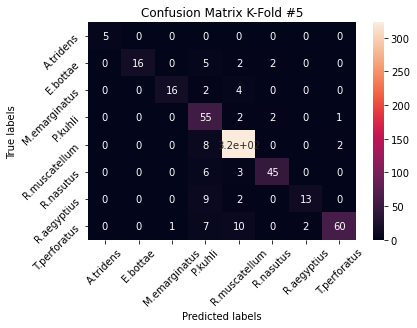

In [13]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  22    0    1    0    0    0    2    0]
 [   0  103    1    6    8    5    0    1]
 [   0    0   84    4   14    0    4    6]
 [   0    3   12  261   10    6    1    6]
 [   0    5    8    8 1622    0    1   21]
 [   0    5    1   16    6  236    1    4]
 [   0    1   17   11   12    0   72    8]
 [   0    0   10    7   20    0    3  363]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  20   0   1   1   1   0   0]
 [  0   0  16   0   2   0   0   1]
 [  0   0   2  52   2   1   0   1]
 [  0   1   1   1 324   0   0   4]
 [  0   1   0   3   1  47   0   0]
 [  0   0   3   2   2   0  14   1]
 [  0   0   2   1   4   0   0  72]]


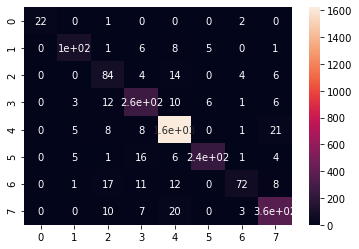

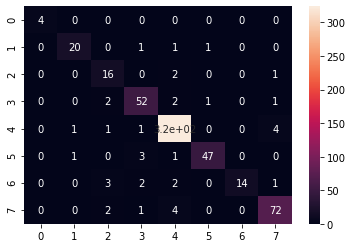

In [14]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.88 0.   0.04 0.   0.   0.   0.08 0.  ]
 [0.   0.83 0.01 0.05 0.06 0.04 0.   0.01]
 [0.   0.   0.75 0.04 0.12 0.   0.04 0.05]
 [0.   0.01 0.04 0.87 0.03 0.02 0.   0.02]
 [0.   0.   0.   0.   0.97 0.   0.   0.01]
 [0.   0.02 0.   0.06 0.02 0.88 0.   0.01]
 [0.   0.01 0.14 0.09 0.1  0.   0.6  0.07]
 [0.   0.   0.02 0.02 0.05 0.   0.01 0.9 ]]


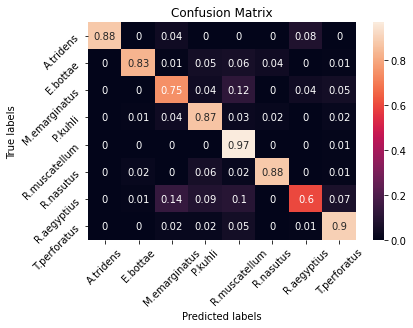

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);